In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

In [16]:

# Two-dimensional target distribution function
def target_distribution(x):
    return stats.norm.pdf(x[0], loc=0, scale=1) * stats.norm.pdf(x[1], loc=0, scale=1)

# Proposal distribution for two-dimensional theta
def proposal_distribution(theta, sigma=0.5):
    return theta + np.random.normal(0, sigma, size=theta.shape)

# Function to compute correction factor
def compute_correction_factor(num_points, sigma):
    def objective(C_sigma):
        convolved = np.convolve(stats.norm.cdf(np.linspace(-3*sigma, 3*sigma, num_points)/sigma), C_sigma, mode='same')
        S = 1 / (1 + np.exp(-np.linspace(-3*sigma, 3*sigma, num_points)))
        return np.sum(np.abs(convolved - S))

    initial_guess = np.ones(num_points) / num_points
    result = minimize(objective, initial_guess, method='SLSQP')
    return np.mean(result.x) if result.success else 1.0

# Function to create correction distribution
def create_correction_distribution_function(average_correction_factor, scale=1):
    def correction_distribution():
        return np.random.normal(average_correction_factor, scale)
    return correction_distribution

# Function to compute statistics (Δ*, sample variance, error)
def compute_statistics(current, proposed, minibatch, target_distribution):
    lambda_values = []
    for x in minibatch:
        current_density = target_distribution(current)
        proposed_density = target_distribution(proposed)
        lambda_value = np.log(proposed_density / current_density)
        lambda_values.append(lambda_value)
    lambda_values = np.array(lambda_values)

    delta_star = np.mean(lambda_values)
    sample_variance = np.var(lambda_values)

    # First and third moments for error estimation
    first_moment = np.mean(np.abs(lambda_values - delta_star))
    third_moment = np.mean(np.abs(lambda_values - delta_star)**3)

    # Error estimate
    error = (6.4 * third_moment / np.sqrt(len(minibatch))) + (2 * first_moment / len(minibatch))
    return delta_star, sample_variance, error


# Minibatch acceptance test function
def minibatch_acceptance_test(current, proposed, minibatch, target_distribution, correction_distribution, delta_threshold, error_tolerance):
    global final_minibatch_size
    delta_star, sample_variance, error = compute_statistics(current, proposed, minibatch, target_distribution)
    while sample_variance >= 1 or error > error_tolerance:
        additional_samples = np.random.choice(data, m, replace=False)
        minibatch = np.concatenate((minibatch, additional_samples))
        delta_star, sample_variance, error = compute_statistics(current, proposed, minibatch, target_distribution)
    final_minibatch_size = len(minibatch)
    X_nc = np.random.normal(0, np.sqrt(1 - sample_variance))
    X_corr = correction_distribution()
    return delta_star + X_nc + X_corr > 0

# MCMC sampling with minibatches for two-dimensional theta
def mcmc_with_minibatch(T, m, delta, correction_distribution, initial_sample, proposal_distribution, target_distribution, data):
    samples = [initial_sample]
    theta = initial_sample
    accepted = 0

    for _ in range(T):
        theta_prime = proposal_distribution(theta)
        minibatch_indices = np.random.choice(len(data), m, replace=False)
        minibatch = data[minibatch_indices]

        if minibatch_acceptance_test(theta, theta_prime, minibatch, target_distribution, correction_distribution, 1, delta):
            theta = theta_prime
            accepted += 1
        samples.append(theta)

    acceptance_rate = accepted / T
    print(f"Acceptance Rate: {acceptance_rate}")
    return samples

# Prepare the dataset and parameters
final_minibatch_size = 0
T = 10000  # Reduced number of samples for speed
m = 50   
delta = 0.1  # Error bound
average_correction_factor = compute_correction_factor(num_points=100, sigma=0.5)
correction_distribution = create_correction_distribution_function(average_correction_factor)
initial_sample = np.array([0, 0])  # Starting point in the parameter space
data = np.random.normal(0, 1, (1000, 2))  # Simulated dataset

# Run the Metropolis-Hastings algorithm
samples = mcmc_with_minibatch(T, m, delta, correction_distribution, initial_sample, proposal_distribution, target_distribution, data)


# Calculate and print the mean and variance for each dimension of the samples
mean_of_samples = np.mean(samples, axis=0)
variance_of_samples = np.var(samples, axis=0)
print(f"Mean of Samples: {mean_of_samples}")
print(f"Variance of Samples: {variance_of_samples}")


Acceptance Rate: 0.6791
Mean of Samples: [0.09177026 0.04612045]
Variance of Samples: [1.68275793 1.46693263]


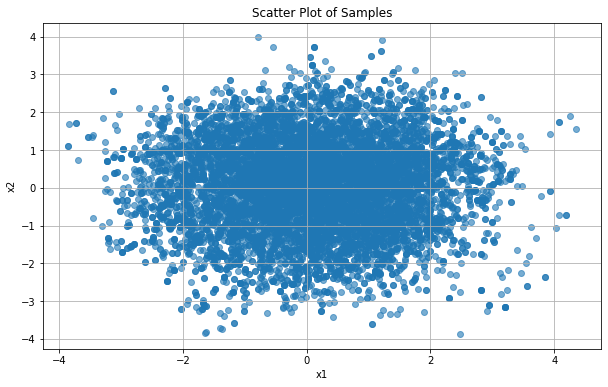

In [21]:
# Convert the list of samples to a NumPy array for easier manipulation
sample_array = np.array(samples)

plt.figure(figsize=(10, 6))
plt.scatter(sample_array[:, 0], sample_array[:, 1], alpha=0.6)
plt.title('Scatter Plot of Samples')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

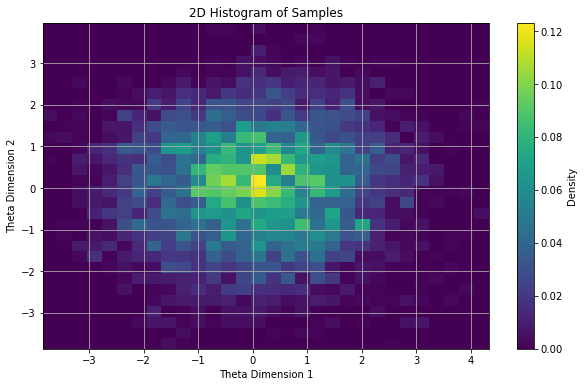

In [22]:
plt.figure(figsize=(10, 6))
plt.hist2d(sample_array[:, 0], sample_array[:, 1], bins=30, density=True)
plt.colorbar(label='Density')
plt.title('2D Histogram of Samples')
plt.xlabel('Theta Dimension 1')
plt.ylabel('Theta Dimension 2')
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Target Distribution')

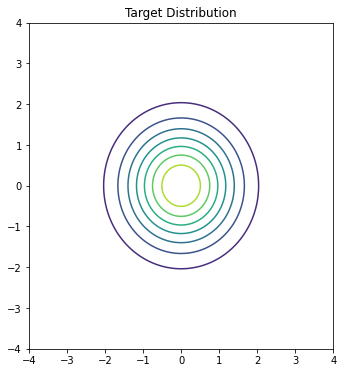

In [23]:
# Define the grid for the contour plot
x = np.linspace(-4, 4, 400)
y = np.linspace(-4, 4, 400)
X, Y = np.meshgrid(x, y)

Z = stats.multivariate_normal.pdf(np.dstack((X, Y)), mean=[0, 0], cov=[[1, 0], [0, 1]])

# Create the contour plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.contour(X, Y, Z)
plt.title('Target Distribution')


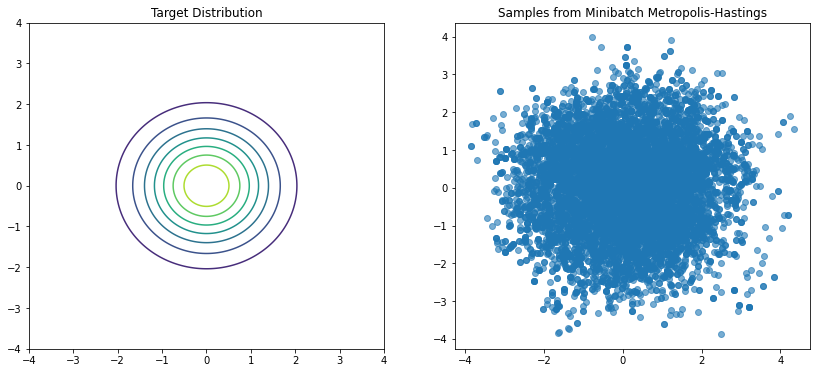

In [24]:

samples_array = np.array(samples)

# Define the grid for the contour plot
x = np.linspace(-4, 4, 400)
y = np.linspace(-4, 4, 400)
X, Y = np.meshgrid(x, y)

mean = np.array([0, 0])
covariance_matrix = np.array([[1, 0], [0, 1]])
Z = multivariate_normal(mean=mean, cov=covariance_matrix).pdf(np.dstack((X, Y)))

# Set up the figure
plt.figure(figsize=(14, 6))

# Contour plot for the target distribution
plt.subplot(1, 2, 1)
plt.contour(X, Y, Z)
plt.title('Target Distribution')

# Scatter plot for the samples
plt.subplot(1, 2, 2)
plt.scatter(samples_array[:, 0], samples_array[:, 1], alpha=0.6)
plt.title('Samples from Minibatch Metropolis-Hastings')

# Show the plots
plt.show()

